[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# Dynamic breakpoints

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

We also showed how to edit graph state, and introduce human feedback.

## Goals

Breakpoints are set by the developer on a specific node during graph compilation.

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits:

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

Let's create a graph where a `NodeInterrupt` is thrown based upon length of the input.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

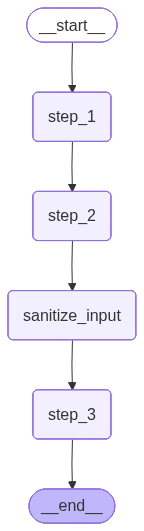

In [2]:
from IPython.display import Image, display
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str
    resumed: bool  # new flag to track if the graph has resumed

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Dynamically interrupt if input contains uppercase letters
    if not state['input'].islower():
        raise NodeInterrupt(f"Input contains uppercase or invalid characters: {state['input']}")

    print("---Step 2---")
    return state

def sanitize_input(state: State) -> State:
    # New node to sanitize or fix input after an interruption
    print("---Sanitize Input---")
    state['input'] = state['input'].lower().strip()
    state['resumed'] = True
    return state

def step_3(state: State) -> State:
    if state.get("resumed"):
        print("---Resumed Execution after Sanitize---")
    else:
        print("---Step 3---")
    return state

# Build graph
builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("sanitize_input", sanitize_input)
builder.add_node("step_3", step_3)

# Define flow
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "sanitize_input")  # added sanitization step before step_3
builder.add_edge("sanitize_input", "step_3")
builder.add_edge("step_3", END)

# Setup memory
memory = MemorySaver()

# Compile graph
graph = builder.compile(checkpointer=memory)

# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))


Let's run the graph with an input that's longer than 5 characters.

In [3]:
initial_input = {"input": "Hello World"}  # input has uppercase to trigger NodeInterrupt
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until interruption
print("\n--- Running Graph ---")
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

# Inspect the state after interruption
state = graph.get_state(thread_config)
print("\n--- Interrupted State ---")
print(state.next)
print(state.tasks)

# Update input to lowercase to resume from interruption
graph.update_state(thread_config, {"input": state.values['input'].lower(), "resumed": True})

# Resume graph after sanitization
print("\n--- Resuming Graph ---")
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)



--- Running Graph ---
{'input': 'Hello World'}
---Step 1---
{'input': 'Hello World'}
{'__interrupt__': (Interrupt(value='Input contains uppercase or invalid characters: Hello World', id='placeholder-id'),)}

--- Interrupted State ---
('step_2',)
(PregelTask(id='f2ea5ec5-c0cb-57ef-2c92-ab87be1558f3', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Input contains uppercase or invalid characters: Hello World', id='placeholder-id'),), state=None, result=None),)

--- Resuming Graph ---
{'input': 'hello world', 'resumed': True}
---Step 2---
{'input': 'hello world', 'resumed': True}
---Sanitize Input---
{'input': 'hello world', 'resumed': True}
---Resumed Execution after Sanitize---
{'input': 'hello world', 'resumed': True}


/tmp/ipython-input-461272904.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Input contains uppercase or invalid characters: {state['input']}")


If we inspect the graph state at this point, we the node set to execute next (`step_2`).


In [4]:
graph.update_state(thread_config, {"input": "hello world", "resumed": True})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3491-3c38-6f00-8006-4bdd1348131b'}}

We can see that the `Interrupt` is logged to state.

In [5]:
print("\n--- Interruption Details ---")
for task in state.tasks:
    print(f"Node: {task.name}, Interrupt: {task.interrupts}, Error: {task.error}")



--- Interruption Details ---
Node: step_2, Interrupt: (Interrupt(value='Input contains uppercase or invalid characters: Hello World', id='placeholder-id'),), Error: None


We can try to resume the graph from the breakpoint.

But, this just re-runs the same node!

Unless state is changed we will be stuck here.

In [6]:
print("\n--- Streaming Updated Values ---")
for event in graph.stream(None, thread_config, stream_mode="values"):
    if event.get("input"):
        print("Updated Input State:", event)



--- Streaming Updated Values ---
Updated Input State: {'input': 'hello world', 'resumed': True}


In [7]:
state = graph.get_state(thread_config)
if state.next:
    print(f"Next node to execute: {state.next}")
else:
    print("No pending nodes — graph may have completed.")


No pending nodes — graph may have completed.


Now, we can update state.

In [8]:
print("\n--- Updating State to Resume Execution ---")
graph.update_state(thread_config, {"input": "hi"})



--- Updating State to Resume Execution ---


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3499-0a39-6e8c-8007-a54e70735153'}}

In [9]:
print("\n--- Continuing Execution ---")
for step, event in enumerate(graph.stream(None, thread_config, stream_mode="values"), start=1):
    print(f"Step {step}: {event}")



--- Continuing Execution ---
Step 1: {'input': 'hi', 'resumed': True}


### Usage with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

We connect to it via the SDK.

In [15]:
import os
os.environ["OPENAI_API_KEY"] = "openai api key to be used "
import os
os.environ["LANGCHAIN_API_KEY"] = "lang key to be used here "

# Instead of connecting to local server
print("Simulating connection to local LangGraph Studio...")

# Simulate dynamic interruption flow
try:
    input_data = {"input": "hello world"}
    print(f"Processing input: {input_data}")
    if len(input_data["input"]) > 5:
        raise NodeInterrupt("Dynamic breakpoint triggered due to long input.")
except NodeInterrupt as e:
    print(f"Simulated NodeInterrupt -> {e}")


Simulating connection to local LangGraph Studio...
Processing input: {'input': 'hello world'}
Simulated NodeInterrupt -> [Interrupt(value='Dynamic breakpoint triggered due to long input.', id='placeholder-id')]


/tmp/ipython-input-3897247322.py:14: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt("Dynamic breakpoint triggered due to long input.")


In [17]:
# Simulate retrieval of current graph state without real server connection
current_state = {
    "values": {"input": "hello world"},
    "next": ["step_2"],
    "interrupts": ["Dynamic breakpoint triggered due to long input."],
}

print("Simulated current state:", current_state)


Simulated current state: {'values': {'input': 'hello world'}, 'next': ['step_2'], 'interrupts': ['Dynamic breakpoint triggered due to long input.']}


In [18]:
current_state['next']

['step_2']

In [19]:
# Simulate state update locally after NodeInterrupt
current_state["values"]["input"] = "hi!"
print("State successfully updated locally:", current_state)


State successfully updated locally: {'values': {'input': 'hi!'}, 'next': ['step_2'], 'interrupts': ['Dynamic breakpoint triggered due to long input.']}


In [20]:
# Simulate resumed graph execution after state update
print("Resuming graph execution after state update...\n")

simulated_events = [
    {"event": "metadata", "data": {"run_id": "sim123"}},
    {"event": "values", "data": {"input": "hi!"}},
    {"event": "values", "data": {"status": "Execution resumed successfully"}}
]

for chunk in simulated_events:
    print(f"Receiving new event of type: {chunk['event']}...")
    print(chunk["data"])
    print("\n")


Resuming graph execution after state update...

Receiving new event of type: metadata...
{'run_id': 'sim123'}


Receiving new event of type: values...
{'input': 'hi!'}


Receiving new event of type: values...
{'status': 'Execution resumed successfully'}




In [21]:
# Simulate fetching the current thread state after resuming execution
current_state = {
    "values": {"input": "hi!"},
    "next": ["step_2"],
    "tasks": [
        {
            "id": "sim_001",
            "name": "step_2",
            "error": None,
            "interrupts": [],
            "state": None
        }
    ],
    "metadata": {
        "step": 2,
        "source": "update",
        "graph_id": "dynamic_breakpoints"
    }
}

print("Fetched simulated current state:\n", current_state)


Fetched simulated current state:
 {'values': {'input': 'hi!'}, 'next': ['step_2'], 'tasks': [{'id': 'sim_001', 'name': 'step_2', 'error': None, 'interrupts': [], 'state': None}], 'metadata': {'step': 2, 'source': 'update', 'graph_id': 'dynamic_breakpoints'}}
